# Exam paper: Optimal Energy mix in Greenland
### _Group 1: Marie Louise, Sofie & Caroline_

We import the basic packages:

In [1]:
%run stdPackages.ipynb

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pyDbs import *
from IPython.display import Image
figs_path = os.path.join(d['curr'],'Figs')


We create a path to data

In [4]:
import os 
path_to_data = os.path.join(d['curr'],'Data','EE_exam data_version2.xlsx')
print(path_to_data)

c:\Users\CAAL\OneDrive - COWI\Desktop\Nuuk-Energy-mix\Exercises\E44\Data\EE_exam data_version2.xlsx


In [5]:
#solution['Generation'].groupby(level=0).plot()
#solution['LoadVariation'].plot()
#solution['Generation']
#solution['Load']*db['LoadGeneration'].plot()

In [6]:
kwargs = {'variables': ['Fundamentals', 'Load', 'Generators_Other'],
        'maps': ['Generators_Categories','hMaps'],
        'variable2D': ['HourlyVariation','Generators_FuelMix', 'Precipitation'],
        'scalars': ['Scalars']}

db = read.dbFromWB(path_to_data, kwargs)
readSets(db)

Finally, make sure your code is correct by solving for the baseline scenario, where this is no storage:

In [7]:
from Exam import *
m = mSimple(db)
m()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


__Control__

We control if we leave _charge_ out of the model, since we set it exogeniously

In [8]:
m.db.symbols.keys()

dict_keys(['EmissionIntensity', 'EmissionTax', 'FuelPrice', 'Load', 'LoadVariation', 'GeneratingCapacity', 'effS', 'sCap', 'OtherMC', 'id2hvt', 'id2tech', 'h2HourOfTheDay', 'h2Weekday', 'h2Week', 'h2Month', 'CapVariation', 'FuelMix', 'Precipitation', 'MWP', 'hydro_scalar', 'BFt', 'EmissionType', 'c', 'h', 'id', 'hvt', 'h_constr', 'id_constr', 'mc', 'discharge', 'Generation', 'HourlyDemand', 'stored', 'λ_LawOfMotion', 'λ_equilibrium', 'λ_discharge', 'λ_Generation', 'λ_HourlyDemand', 'λ_stored', 'Welfare', 'meanConsumerPrice', 'capacityFactor', 'marginalSystemCosts', 'marginalEconomicValue', 'capturePrice', 'marketValueFactor', 'consumerSurplus', 'producerSurplus'])

Save solution for later:

In [9]:
base_db = m.db.copy()

In the following, we aggregate the fuel types to the following types:

In [10]:
agg_BFt = {
    'Fueloil':'Oil','Gasoil':'Oil', 
    'Straw':'Biomass','WoodPellets':'Biomass','WoodChips':'Biomass','WoodWaste':'Biomass',
    'Biogas':'Other Bio','BioOil':'Other Bio',
    'Coal':'Coal',
    'NatGas':'Natural gas',
    'Waste':'Waste'
}

### __Descriptives__

In [11]:
#m.db['HourlyDemand']['c1', :].plot()
#plt.title('Hourly demand in electricity')

# The optimal combination of wind and hydro

First, we define the vectors. 

Since Buksefjordsværket in Nuuk already has a capacity of 45 mW, and the planned expantion of the hydro power plant is 55 mW (in all 100 mW), the vector of hydro goes from 45 to 100. 

Thus, the vector of wind goes from 0 to 55 mW. 

Each vector contains five points, and so we have 25 combinations of hydro and wind.

In [12]:
# Defining vectors for wind and hydro
vec_hydro = np.linspace(45, 100, 5)
vec_wind = np.linspace(0, 55, 5)

# printing vectors
print("Vector for hydro:", vec_hydro)
print("Vector for wind:", vec_wind)

Vector for hydro: [ 45.    58.75  72.5   86.25 100.  ]
Vector for wind: [ 0.   13.75 27.5  41.25 55.  ]


### __Electricity__

Secondly, we create two dataframes representing electricity capacity of hydro and wind, respectively. 

In [13]:
# defining of minimum electricity
min_elec = [vec_hydro[0], vec_wind[0]]

# definition of max electricity
max_elec = [vec_hydro[4], vec_wind[4]]

# Defining the loop
loop = pd.RangeIndex(25, name='loop')

# lower and upper bound for hydro
v0_ECap_Hydro = pd.Series(min_elec[0], index=getTechs(['Storage'], m.db))
vT_ECap_Hydro = pd.Series(max_elec[0], index=getTechs(['Storage'], m.db))

# Grid for hydro
grid_ECap_Hydro = pd.Series([vec_hydro[i] for i in range(5) for _ in range(5)], index=pd.MultiIndex.from_product([loop, [db['id'][-1]]], names=['loop', 'id']), name='GeneratingCapacity')

# lower and upper bound for wind
v0_ECap_Wind = pd.Series(min_elec[1], index=getTechs(['Standard'], m.db))
vT_ECap_Wind = pd.Series(max_elec[1], index=getTechs(['Standard'], m.db))

# grid for wind
grid_ECap_Wind = pd.Series([vec_wind[i] for _ in range(5) for i in range(5)], index=pd.MultiIndex.from_product([loop, [db['id'][0]]], names=['loop', 'id']), name='GeneratingCapacity')


### __Storage__

Third, we create a dataframe representing storage capacity based on the reservior of the hydro power plant

In [14]:
# The "energy storage to power"-ratio/storage duration 
E2P = 5000

# Defining min storage
min_storage = vec_hydro[0]

# defining max storage
max_storage = vec_hydro[4]

# Defining a storage vector
vec_storage = np.linspace(min_storage, max_storage, 5)*E2P

# defining lower and upper bound for electricity storage by multiplying E2P with the energy production
v0_SCap = pd.Series(min_storage, index = getTechs(['Storage'], m.db))*E2P
vT_SCap = pd.Series(max_storage, index = v0_SCap.index)*E2P

# Second grid with a storage cap running through loop 2
grid_SCap = pd.Series([vec_storage[i] for i in range(5) for _ in range(5)], index=pd.MultiIndex.from_product([loop, db['sCap'].index], names=['loop', 'id']), name='sCap')

### __Scalar of precipitation__ 

In [15]:
# Defining min storage
min_hydro_scalar = 1

# defining max storage
max_hydro_scalar = 6

# Defining a storage vector
vec_hydro_scalar = np.linspace(min_hydro_scalar, max_hydro_scalar, 5)

# defining lower and upper bound for electricity storage by multiplying E2P with the energy production
v0_HydroScalar = pd.Series(min_hydro_scalar)
vT_HydroScalar = pd.Series(max_hydro_scalar)

# Second grid with a storage cap running through loop 2
grid_HydroScalar = pd.Series([vec_hydro_scalar[i] for i in range(5) for _ in range(5)], index=loop, name='hydro_scalar')

### __Solving the model__

Then, we extract the relevant variables to solve the model:

In [16]:
list(m.db.symbols.keys())

['EmissionIntensity',
 'EmissionTax',
 'FuelPrice',
 'Load',
 'LoadVariation',
 'GeneratingCapacity',
 'effS',
 'sCap',
 'OtherMC',
 'id2hvt',
 'id2tech',
 'h2HourOfTheDay',
 'h2Weekday',
 'h2Week',
 'h2Month',
 'CapVariation',
 'FuelMix',
 'Precipitation',
 'MWP',
 'hydro_scalar',
 'BFt',
 'EmissionType',
 'c',
 'h',
 'id',
 'hvt',
 'h_constr',
 'id_constr',
 'mc',
 'discharge',
 'Generation',
 'HourlyDemand',
 'stored',
 'λ_LawOfMotion',
 'λ_equilibrium',
 'λ_discharge',
 'λ_Generation',
 'λ_HourlyDemand',
 'λ_stored',
 'Welfare',
 'meanConsumerPrice',
 'capacityFactor',
 'marginalSystemCosts',
 'marginalEconomicValue',
 'capturePrice',
 'marketValueFactor',
 'consumerSurplus',
 'producerSurplus']

In [17]:
extract = ['capturePrice', 'LoadVariation', 'GeneratingCapacity', 'marginalSystemCosts','Generation', 'discharge','capturePrice','marketValueFactor','capacityFactor','marginalEconomicValue','consumerSurplus','producerSurplus','Welfare']

And finally, we solve the model:

In [18]:
solution = m.loopSolveExtract(loop, [grid_ECap_Wind, grid_ECap_Hydro, grid_SCap, grid_HydroScalar], extract)

In [48]:
solution['Welfare']

loop
0     1.129032e+07
1     1.387739e+07
2     1.646446e+07
3     1.905152e+07
4     2.163859e+07
5     2.540322e+07
6     2.799029e+07
7     3.057736e+07
8     3.316443e+07
9     3.575149e+07
10    3.575149e+07
11    3.575149e+07
12    3.575149e+07
13    3.575149e+07
14    3.575149e+07
15    3.575149e+07
16    3.575149e+07
17    3.575149e+07
18    3.575149e+07
19    3.575149e+07
20    3.575149e+07
21    3.575149e+07
22    3.575149e+07
23    3.575149e+07
24    3.575149e+07
dtype: float64

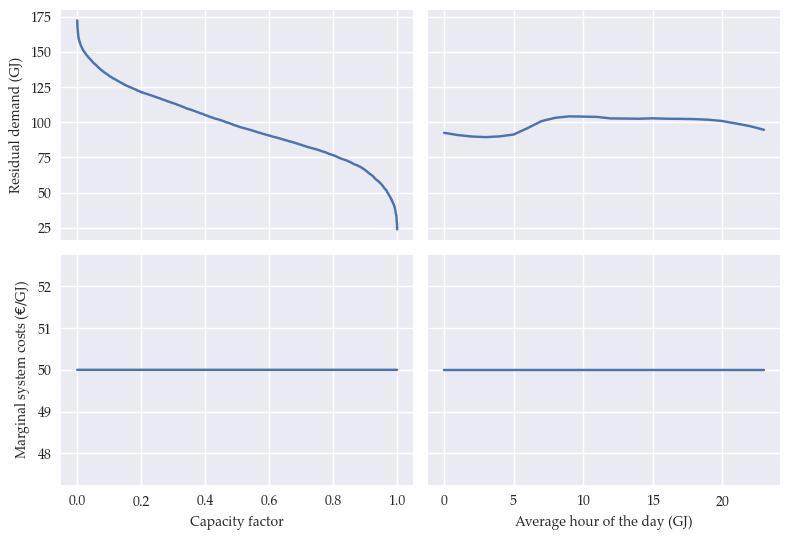

In [20]:
# Make dataframe
int_id = adj.rc_pd(m.db['id2hvt'], pd.Index(['Wind'], name = 'hvt')).droplevel('hvt')
df_sort =  pd.concat([
    adj.rc_pd(m.hourlyGeneratingCap,int_id).groupby('h').sum().rename('E').astype(float),
    m.hourlyLoad.rename('L').astype(float),
    m.db['marginalSystemCosts'].rename('p').astype(float)
],axis=1)

# Calculate residual demand
df_sort['resd'] = df_sort['L']-df_sort['E']

# Sort dataframe
df_sort = df_sort.sort_values(['resd'],ascending=False).reset_index()
df_sort.index = df_sort.index/len(df_sort)

# Make new dataframe with time mappings
df_h = df_sort.merge(m.db['h2HourOfTheDay'].to_frame(index=False))

# Aggregate for average hour of the day
df_h = df_h.groupby('HourOfTheDay')[['resd','p']].mean()

# Make plot
fig, ax = plt.subplots(nrows=2,ncols=2,sharey='row',sharex='col')

df_sort['resd'].plot(ax=ax[0,0],ylabel=r'Residual demand (GJ)')
df_sort['p'].plot(ax=ax[1,0],ylabel=r'Marginal system costs ($€/$GJ)',xlabel='Capacity factor')
df_h['resd'].plot(ax=ax[0,1])
df_h['p'].plot(xlabel='Average hour of the day (GJ)',ax=ax[1,1])

fig.tight_layout()

In [21]:
m.db['GeneratingCapacity']

id
id1      55.0
idES    100.0
Name: GeneratingCapacity, dtype: float64

_skal opdateres manuelt_

In [46]:
tabel_data = {
    'Combination': [(0, 45), (13, 45), (27, 45), (41, 45), (55, 45), 
                    (0, 58), (13, 58), (27, 58), (41, 58), (55, 58), 
                    (0, 72), (13, 72), (27, 72), (41, 72), (55, 72), 
                    (0, 86), (13, 86), (27, 86), (41, 86), (55, 86), 
                    (0, 100), (13, 100), (27, 100), (41, 100), (55, 100)],
    'Welfare': [
    1.129032e+07,
    1.379460e+07,
    1.629888e+07,
    1.880317e+07,
    2.130745e+07,
    1.834677e+07,
    2.085105e+07,
    2.335534e+07,
    2.585962e+07,
    2.836390e+07,
    2.540322e+07,
    2.790751e+07,
    3.041179e+07,
    3.291607e+07,
    3.542035e+07,
    3.245968e+07,
    3.496396e+07,
    3.746824e+07,
    3.997252e+07,
    4.077007e+07,
    3.951613e+07,
    4.081028e+07,
    4.153236e+07,
    4.195788e+07,
    4.219535e+07
]
}


# Create a DataFrame
tabel_df = pd.DataFrame(tabel_data)

# Print the DataFrame
print(tabel_df)


   Combination     Welfare
0      (0, 45)  11290320.0
1     (13, 45)  13794600.0
2     (27, 45)  16298880.0
3     (41, 45)  18803170.0
4     (55, 45)  21307450.0
5      (0, 58)  18346770.0
6     (13, 58)  20851050.0
7     (27, 58)  23355340.0
8     (41, 58)  25859620.0
9     (55, 58)  28363900.0
10     (0, 72)  25403220.0
11    (13, 72)  27907510.0
12    (27, 72)  30411790.0
13    (41, 72)  32916070.0
14    (55, 72)  35420350.0
15     (0, 86)  32459680.0
16    (13, 86)  34963960.0
17    (27, 86)  37468240.0
18    (41, 86)  39972520.0
19    (55, 86)  40770070.0
20    (0, 100)  39516130.0
21   (13, 100)  40810280.0
22   (27, 100)  41532360.0
23   (41, 100)  41957880.0
24   (55, 100)  42195350.0


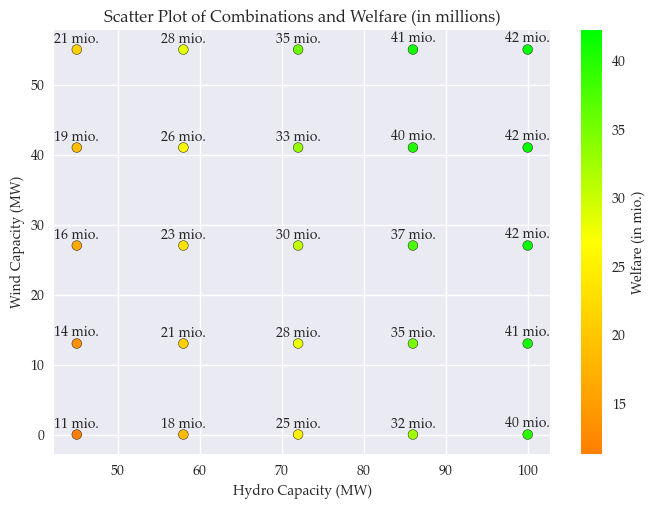

In [23]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

# Assuming df is your DataFrame
tabel_df = pd.DataFrame(tabel_data)

# Extract x and y values
combinations = tabel_df['Combination']
welfare = tabel_df['Welfare'] / 1e6  # Convert welfare values to millions

# Unpack the tuples in the 'Combination' column
y, x = zip(*combinations)

# Define a custom colormap from orange to green
colors = [(1, 0.5, 0), (1, 1, 0), (0, 1, 0)]  # RGB values for orange, yellow, and green
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Normalize welfare values to the range [0, 1] for the colormap
norm = Normalize(vmin=welfare.min(), vmax=welfare.max())

# Create a scatter plot with swapped x and y, using the custom colormap
plt.scatter(x, y, c=welfare, cmap=cmap, norm=norm, marker='o', edgecolors='black')

# Add labels and a colorbar
plt.xlabel('Hydro Capacity (MW)')
plt.ylabel('Wind Capacity (MW)')
plt.title('Scatter Plot of Combinations and Welfare (in millions)')
cbar = plt.colorbar()
cbar.set_label('Welfare (in mio.)')

# Add welfare value annotations for each combination
for i, (xi, yi, wi) in enumerate(zip(x, y, welfare)):
    plt.annotate(f'{wi:.0f} mio.', (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center')

# Show the plot
plt.show()


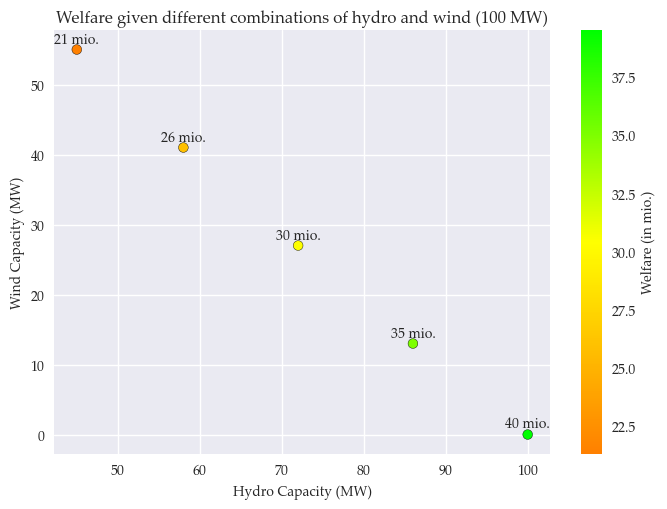

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

# Assuming df is your DataFrame
df_tabel = pd.DataFrame(tabel_data)

# Define the tolerance for the sum of wind and hydro capacities
tolerance = 5

# Filter combinations where the sum of wind and hydro capacities is close to 100
filtered_df = df_tabel[df_tabel['Combination'].apply(lambda x: abs(sum(x) - 100) <= tolerance)]

# Extract x and y values from the filtered DataFrame
combinations = filtered_df['Combination']
welfare = filtered_df['Welfare'] / 1e6  # Convert welfare values to millions

# Unpack the tuples in the 'Combination' column
y, x = zip(*combinations)

# Define a custom colormap from orange to green
colors = [(1, 0.5, 0), (1, 1, 0), (0, 1, 0)]  # RGB values for orange, yellow, and green
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Normalize welfare values to the range [0, 1] for the colormap
norm = Normalize(vmin=welfare.min(), vmax=welfare.max())

# Create a scatter plot with swapped x and y, using the custom colormap
plt.scatter(x, y, c=welfare, cmap=cmap, norm=norm, marker='o', edgecolors='black')

# Add labels and a colorbar
plt.xlabel('Hydro Capacity (MW)')
plt.ylabel('Wind Capacity (MW)')
plt.title('Welfare given different combinations of hydro and wind (100 MW)')
cbar = plt.colorbar()
cbar.set_label('Welfare (in mio.)')

# Add welfare value annotations for each combination
for i, (xi, yi, wi) in enumerate(zip(x, y, welfare)):
    plt.annotate(f'{wi:.0f} mio.', (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center')

# Show the plot
plt.show()


In [25]:
db['Load']

c
c1    1071214.6
Name: Load, dtype: object

Text(0.5, 1.0, 'Welfare in different combinations of hydro and wind')

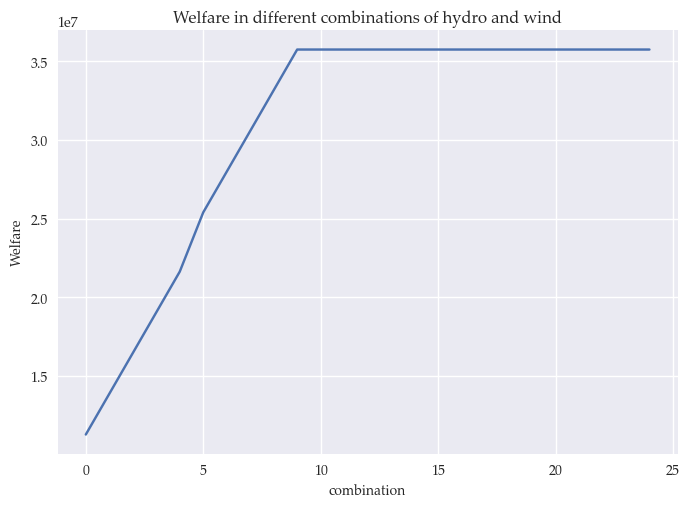

In [47]:
solution['Welfare'].plot()
plt.xlabel('combination')
plt.ylabel('Welfare')
plt.title('Welfare in different combinations of hydro and wind')

In [27]:
solution['capturePrice']

id   loop
id1  0        0.0
     1       50.0
     2       50.0
     3       50.0
     4       50.0
     5        0.0
     6       50.0
     7       50.0
     8       50.0
     9       50.0
     10      50.0
     11      50.0
     12      50.0
     13      50.0
     14      50.0
     15      50.0
     16      50.0
     17      50.0
     18      50.0
     19      50.0
     20      50.0
     21      50.0
     22      50.0
     23      50.0
     24      50.0
dtype: float64

In [28]:
solution['Welfare'][grid_ECap_Wind[grid_ECap_Wind == 55].index.get_level_values(0)]

loop
4     2.163859e+07
9     3.575149e+07
14    3.575149e+07
19    3.575149e+07
24    3.575149e+07
dtype: float64

In [29]:
db['sCap'].index.names

FrozenList(['id'])

In [30]:
db['MWP']

50

In [31]:
solution['Generation']

h     id   loop
1     id1  0        0.000000
           1        4.481481
           2        8.962963
           3       13.444444
           4       17.925926
                     ...    
8760  id1  20       7.333333
           21       7.333333
           22       7.333333
           23       7.333333
           24       7.333333
Length: 219000, dtype: float64

### __Results__

In [32]:
solution['discharge'][:, :, 0].groupby('id').sum()

id
idES    225806.451613
dtype: float64

In [33]:
solution['discharge'][:, :, 12].groupby('id').sum()

id
idES    508064.516129
dtype: float64

In [34]:
solution['GeneratingCapacity']['id1']

loop
0      0.00
1     13.75
2     27.50
3     41.25
4     55.00
5      0.00
6     13.75
7     27.50
8     41.25
9     55.00
10     0.00
11    13.75
12    27.50
13    41.25
14    55.00
15     0.00
16    13.75
17    27.50
18    41.25
19    55.00
20     0.00
21    13.75
22    27.50
23    41.25
24    55.00
dtype: float64

In [35]:
solution['discharge'].head(25)

h  id    loop
1  idES  0       45.00
         1       45.00
         2       45.00
         3       45.00
         4       45.00
         5       58.75
         6       58.75
         7       58.75
         8       58.75
         9       58.75
         10      58.75
         11      58.75
         12      58.75
         13      58.75
         14      58.75
         15      58.75
         16      58.75
         17      58.75
         18      58.75
         19      58.75
         20      58.75
         21      58.75
         22      58.75
         23      58.75
         24      58.75
dtype: float64

# Random things

Third, we define a grid with two dimentions, so that the grid contains both electricity generation from hydro and wind

In [36]:
def grid(vec_hydro, vec_wind, index, gridtype='linear', phi=1): 

    if gridtype == 'linear': # If v0, vT are one dimentional numpy arrays, returns two dimentional array. 
        return np.linspace(vec_hydro, vec_wind, len(index)) 
      
    elif gridtype=='polynomial': # If scalars, returns one dimentional arrays.
        return np.array([vec_hydro+(vec_wind-vec_hydro)*((i-1)/(len(index)-1))**phi for i in range(1,len(index)+1)])

In [37]:
def addGrid(vec_hydro, vec_wind, index, name, gridtype = 'linear', phi = 1, sort_levels=None, sort_index = False): # NB: Make sure that v0 and vT are sorted similarly (if they are defined over indices)
    
    if sort_index:
        vec_hydro = vec_hydro.sort_index()
        vec_wind = vec_wind.sort_index()

    if isinstance(vec_hydro, pd.Series):
        return pd.DataFrame(grid(vec_hydro, vec_wind, index, gridtype=gridtype, phi=phi).T, index = vec_hydro.index, columns = index).stack().rename(name).reorder_levels(index.names+vec_wind.index.names if sort_levels is None else sort_levels)
    
    else:
        return pd.Series(grid(vec_hydro, vec_wind, index, gridtype=gridtype, phi=phi), index=index, name=name)

Then, we converge the vectors into flat indexs 

In [38]:
import lpCompiler

In [39]:
df_E = lpCompiler.sortAll(addGrid(grid_ECap, grid_ECap, loop_wind, 'GeneratingCap_E').unstack('id'))
df_S = lpCompiler.sortAll(addGrid(grid_SCap, grid_SCap, loop_hydro, 'sCap').unstack('id'))

# redefining the name of the loops
df_E.index = df_E.index.to_flat_index().rename('loop')
df_S.index = df_S.index.to_flat_index().rename('loop')

# 
grid_ECap_1d = df_E.stack().rename('GenerationCapacity')
grid_SCap_1d = df_S.stack().rename('GenerationCapacity')

# Defining the loop as an index
loop = df_E.index

NameError: name 'grid_ECap' is not defined

In [ ]:
df_E

id,idES,id6
loop,,
"(0, 0)",45.0,0.0
"(0, 1)",45.0,0.0
"(0, 2)",45.0,0.0
"(0, 3)",45.0,0.0
"(0, 4)",45.0,0.0
"(1, 0)",58.0,13.0
"(1, 1)",58.0,13.0
"(1, 2)",58.0,13.0
"(1, 3)",58.0,13.0


Then, we extract the following variables:

Vi har desuden fjernet alle emmissionsvariable, da vi kun har VE-anlæg

Her tilføjes en ekstra variable, da storage muligheden også udvider sig grundet udvidelse af vandkraftværk. Derfor tager det også længere tid at tømme reservioret. Man kan se, at de følges ad --> så reservioret ikke tømmes hurtigere pga. udvidelse heraf men tværdigmod

In [ ]:
grid_SCap_1d2 = (grid_SCap_1d*5000).rename('SCap')

In [ ]:
m.db['Generation'][:, 'id6']

h
1       13.820385
2       13.392084
3       12.850539
4       12.531986
5       12.292986
          ...    
8756    15.981571
8757    14.761723
8758    14.641821
8759    14.080541
8760    13.468162
Length: 8760, dtype: float64

In [ ]:
m.hourlyGeneratingCap['id6'][m.hourlyGeneratingCap['id6'] - m.db['HourlyDemand']['c1', :] < 0].sum()

17792.691162259584

In [ ]:
m.hourlyGeneratingCap['idES'][m.hourlyGeneratingCap['idES']].sum()

876000

In [ ]:
m.globalDomains['LawOfMotion']

MultiIndex([('idES',    1),
            ('idES',    2),
            ('idES',    3),
            ('idES',    4),
            ('idES',    5),
            ('idES',    6),
            ('idES',    7),
            ('idES',    8),
            ('idES',    9),
            ('idES',   10),
            ...
            ('idES', 8751),
            ('idES', 8752),
            ('idES', 8753),
            ('idES', 8754),
            ('idES', 8755),
            ('idES', 8756),
            ('idES', 8757),
            ('idES', 8758),
            ('idES', 8759),
            ('idES', 8760)],
           names=['id_constr', 'h_constr'], length=8760)

<Axes: xlabel='h'>

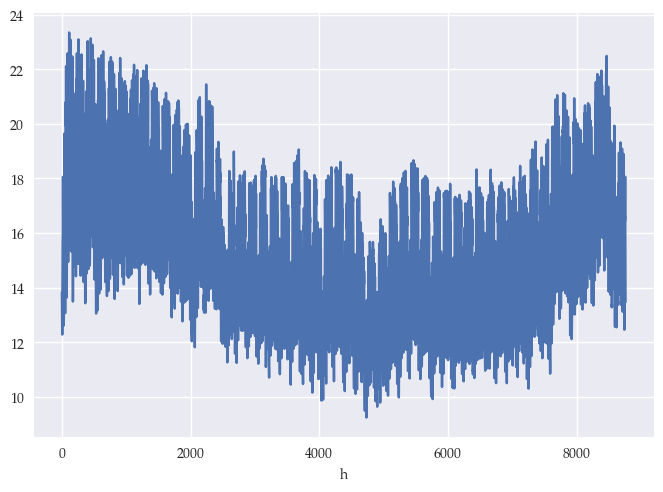

In [ ]:
m.db['HourlyDemand']['c1', :].plot()

In [ ]:
solution['discharge'][:,:,0][solution['discharge'][:, :, 0] >0]

h     id  
1     idES    45.000000
2     idES    45.000000
4     idES    26.084946
5     idES    45.000000
9     idES    45.000000
                ...    
8754  idES    28.022745
8755  idES    45.000000
8757  idES    45.000000
8759  idES    45.000000
8760  idES    45.000000
Length: 5776, dtype: float64

<Axes: xlabel='h'>

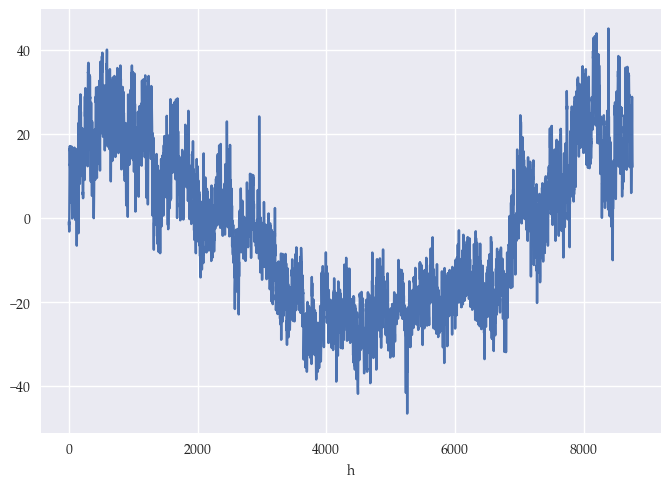

In [ ]:
(m.hourlyLoad - m.hourlyGeneratingCap.xs('idES')).plot()

# Appendix

The table below translates the names used in the data to the symbols used in the model. 

| Name in excel file | Model symbol |
|:--------|:--------:|
| id | $i$ | 
| BFt | $j$ |
| h | $h$ |
|  FuelMix   |  $\mu_{i,j}$   |
|  GeneratingCapacity   | $q_i$   |
|  OtherMC   | $c_i^{oth}$   |
| FuelPrice | $p_j^f$ |
| EmissionIntensity | $\phi_j$ |
| MWP | $\mu$ |
| LoadVariation $\times$ Load | $D_h$ |
| CapVariation | $\gamma_{i,h} $ |
| sCap | $\overline{S}_i$ |
| effS | $\sqrt{\eta_i}$ |

Note that $c$ is also an index for the consumer type in the data file. In the model in [**Part 1**](#Part-1:-Analytical-Exercises), however, there is only a single representative consumer. But since $c=c1$ always, this is equivalent.

The following section imports the data: